In [1]:
import tensorflow as tf
import os
tf.random.set_seed(42)
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/

'Colab Notebooks'   ig_final.keras   my_model_5.keras   my_model_8.keras
 dataset	    model_3.h5	     my_model_6.keras   my_model.h5
 dataset1	    model_4.keras    my_model_7.keras  'research papers(ref)'


In [4]:
# Defining Path
DATASET_PATH = "/content/drive/MyDrive/dataset1"

In [5]:
# Define image size and batch size
IMAGE_SIZE = (224,224) # Resize all images to 224x224 pixel values
BATCH_SIZE = 32        # Number of images per batch

In [6]:
# Load dataset from directory
dataset = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred', # Infer labels from folder names
    label_mode="int",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 6235 files belonging to 4 classes.


In [7]:
# Split the dataset into training, validation, and test sets
train_size = 0.7
val_size = 0.2
test_size = 0.1

In [8]:
# Getting the number of batches
total_batches = tf.data.experimental.cardinality(dataset).numpy()
train_batches = int(total_batches * train_size)
val_batches = int(total_batches * val_size)
print(total_batches,train_batches,val_batches)

195 136 39


In [9]:
# Split the data
train_dataset = dataset.take(train_batches)
remaining = dataset.skip(train_batches)
val_dataset = remaining.take(val_batches)
test_dataset = remaining.skip(val_batches)

In [10]:
for image, label in train_dataset.take(1):
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")

Image shape: (32, 224, 224, 3), Label: [0 1 2 2 3 0 1 1 2 0 2 1 1 2 1 2 1 0 3 3 2 2 2 3 0 3 3 3 2 3 1 0]


In [11]:
print(f"Label shape: {label.shape}, Unique labels: {set(label.numpy())}")

Label shape: (32,), Unique labels: {np.int32(0), np.int32(1), np.int32(2), np.int32(3)}


In [12]:


# Normalize the pizel values to [0,1]
def normalize(image,label):
    image = tf.cast(image,tf.float32) / 255.0
    return image,label

In [13]:
# Prefetch for performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
import tensorflow.keras.backend as K

# Custom function to restrict output between 0 and 4
def bounded_relu(x):
    return K.clip(x, 0, 4)


In [15]:
import tensorflow as tf
from tensorflow.keras import layers,models

In [16]:
# Define the input shape
INPUT_SHAPE = (224,224,3) # Image size with 3 color channels (RGB)

In [17]:
# def preprocess_dataset(dataset):
#     def preprocess(image, label):
#         label = tf.squeeze(label, axis=-1)  # Remove any extra dimensions
#         label = tf.cast(label, tf.int32)  # Convert to integer

#         return image, label

#     return dataset.map(preprocess)

# # Apply corrected preprocessing
# train_dataset = preprocess_dataset(train_dataset)
# val_dataset = preprocess_dataset(val_dataset)
# test_dataset = preprocess_dataset(test_dataset)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import backend as K
import os

# ✅ Define bounded ReLU function
def bounded_relu(x):
    return K.relu(x, max_value=4)

# ✅ Register the function
get_custom_objects()['bounded_relu'] = bounded_relu

# ✅ Define input shape
INPUT_SHAPE = (224, 224, 3)

# ✅ Load EfficientNetB0 (without top layers)
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
base_model.trainable = False  # Freeze pretrained layers

# ✅ Function to build the model
def build_model():
    inputs = Input(shape=INPUT_SHAPE)

    # Feature extraction using EfficientNet
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.3)(x)

    # Additional CNN layers
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    # Flatten and fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)

    # Classification output (5 classes)
    class_output = layers.Dense(5, activation='softmax', name='classification_output')(x)

    # Regression output (bounded ReLU for severity grading)
    # reg_output = layers.Dense(1, activation=bounded_relu, name='bounded_regression_output')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=class_output)
    return model

# ✅ Build the model
model = build_model()

# ✅ Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        "classification_output": "sparse_categorical_crossentropy",
    },
    metrics={
        "classification_output": ["accuracy"],
    }
)

# ✅ Train model for 5 epochs
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 1854s 13s/step - accuracy: 0.3362 - loss: 1.3807 - val_accuracy: 0.3622 - val_loss: 1.3356


In [19]:
# # ✅ Save the model
# model.save("arthritis_model.h5")

# print("✅ Model training complete and saved!")

In [ ]:
model.evaluate(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 231s 9s/step - accuracy: 0.3571 - loss: 1.3447


[1.3512842655181885, 0.34960630536079407]

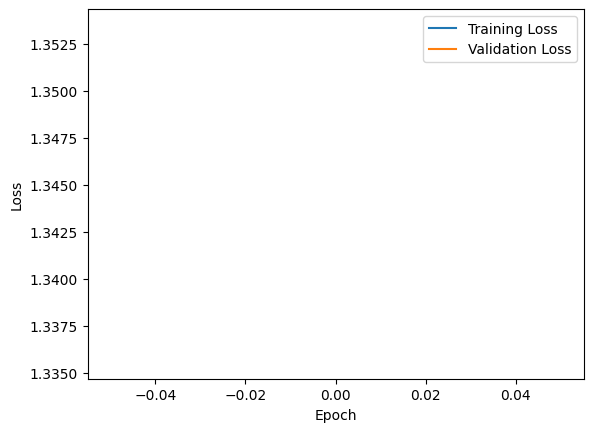

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mounts Google Drive
model.save('/content/drive/My Drive/model_9.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 🌟 Get True Labels and Predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    y_true.extend(tf.argmax(labels, axis=1).numpy())  # Convert one-hot to class indices
    y_pred_probs.extend(model.predict(images))  # Get predictions

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# 📌 1️⃣ Classification Report
print("📄 Classification Report:\n", classification_report(y_true, y_pred))

# 📌 2️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📌 3️⃣ ROC Curve (for multi-class classification)
plt.figure(figsize=(8,6))
num_classes = y_pred_probs.shape[1]

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 📌 4️⃣ Plot Training Loss and Accuracy
history_dict = history.history  # Extract training history
epochs = range(1, len(history_dict["loss"]) + 1)

plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict["loss"], label="Training Loss")
plt.plot(epochs, history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict["accuracy"], label="Training Accuracy")
plt.plot(epochs, history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()

InvalidArgumentError: {{function_node __wrapped__ArgMax_device_/job:localhost/replica:0/task:0/device:CPU:0}} Expected dimension in the range [-1, 1), but got 1 [Op:ArgMax] name: 

In [ ]:
model_path = "/content/drive/My Drive/model_9.keras"

In [ ]:
from keras.models import load_model
from keras.losses import MeanSquaredError
import keras.backend as K

# ✅ Define bounded ReLU properly
def bounded_relu(x):
    return K.relu(x, max_value=1.0)

# ✅ Pass function references in custom objects
custom_objects = {
    "bounded_relu": bounded_relu,
    "MeanSquaredError": MeanSquaredError
}

# ✅ Load the model
model = load_model(model_path, custom_objects=custom_objects)
model.compile(optimizer="adam", loss=MeanSquaredError(), metrics=["mse"])

print("✅ Model Loaded Successfully!")

In [ ]:
from keras.models import load_model
from keras.losses import MeanSquaredError
import keras.backend as K
from keras.utils import get_custom_objects

# ✅ Define bounded ReLU properly
def bounded_relu(x):
    return K.relu(x, max_value=1.0)

# ✅ Register custom activation globally
get_custom_objects().update({"bounded_relu": bounded_relu})

# ✅ Load the model (without needing custom_objects in `load_model`)
model = load_model(model_path)

print("✅ Model Loaded Successfully!")

In [ ]:
from keras.models import load_model
from keras.losses import MeanSquaredError
import keras.backend as K

# Define bounded ReLU again
def bounded_relu(x):
    return K.relu(x, max_value=1.0)

# Define custom objects dictionary
custom_objects = {
    "bounded_relu": bounded_relu,
    "MeanSquaredError": MeanSquaredError
}

# Use Lambda layer with explicit output shape
lambda_layer = Lambda(bounded_relu, output_shape=(5,))

# Load the model with custom objects
model = load_model(model_path, custom_objects=custom_objects)

print("Model Loaded Successfully!")
